In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from scipy import stats

import nfl_data_py as nfl

In [2]:
COLUMN_MAPPINGS = {
    'QB': {
        'Player': 'PLAYER',
        'ATT': 'PASS_ATT',
        'TDS': 'PASS_TD',
        'YDS': 'PASS_YDS',
        'ATT.1': 'RUSH_ATT',
        'TDS.1': 'RUSH_TD',
        'YDS.1': 'RUSH_YDS',
        'CMP': 'CMP',
        'FG': 'FG',
        'FGA': 'FGA',
        'FL': 'FL',
        'FPTS': 'FPTS',
        'INTS': 'INTS',
        'Player': 'Player',
        'REC': 'REC',
        'XPT': 'XPT',
        'position': 'POSITION',
        'week': 'WEEK',
        'expert': 'EXPERT'
    },
    'RB': {
        'Player': 'PLAYER',
        'ATT': 'RUSH_ATT',
        'YDS': 'RUSH_YDS',
        'TDS': 'RUSH_TD',
        'ATT.1': 'PASS_ATT',
        'YDS.1': 'REC_YDS',
        'TDS.1': 'REC_TD',
        'CMP': 'CMP',
        'FG': 'FG',
        'FGA': 'FGA',
        'FL': 'FL',
        'FPTS': 'FPTS',
        'INTS': 'INTS',
        'Player': 'Player',
        'REC': 'REC',
        'XPT': 'XPT',
        'position': 'POSITION',
        'week': 'WEEK',
        'expert': 'EXPERT'
    },
    'WR': {
        'Player': 'PLAYER',
        'ATT': 'RUSH_ATT',
        'TDS': 'RUSH_TD',
        'YDS': 'RUSH_YDS',
        'ATT.1': 'PASS_ATT',
        'TDS.1': 'REC_TD',
        'YDS.1': 'REC_YDS',
        'CMP': 'CMP',
        'FG': 'FG',
        'FGA': 'FGA',
        'FL': 'FL',
        'FPTS': 'FPTS',
        'INTS': 'INTS',
        'Player': 'Player',
        'REC': 'REC',
        'XPT': 'XPT',
        'position': 'POSITION',
        'week': 'WEEK',
        'expert': 'EXPERT'
    },
    'TE': {
        'Player': 'PLAYER',
        'ATT': 'RUSH_ATT',
        'TDS': 'REC_TD',
        'YDS': 'REC_YDS',
        'ATT.1': 'PASS_ATT',
        'TDS.1': 'RUSH_TD',
        'YDS.1': 'RUSH_YDS',
        'CMP': 'CMP',
        'FG': 'FG',
        'FGA': 'FGA',
        'FL': 'FL',
        'FPTS': 'FPTS',
        'INTS': 'INTS',
        'Player': 'Player',
        'REC': 'REC',
        'XPT': 'XPT',
        'position': 'POSITION',
        'week': 'WEEK',
        'expert': 'EXPERT'
    },
    'K': {
        'Player': 'PLAYER',
        'ATT': 'RUSH_ATT',
        'TDS': 'REC_TD',
        'YDS': 'REC_YDS',
        'ATT.1': 'PASS_ATT',
        'TDS.1': 'RUSH_TD',
        'YDS.1': 'RUSH_YDS',
        'CMP': 'CMP',
        'FG': 'FG',
        'FGA': 'FGA',
        'FL': 'FL',
        'FPTS': 'FPTS',
        'INTS': 'INTS',
        'Player': 'Player',
        'REC': 'REC',
        'XPT': 'XPT',
        'position': 'POSITION',
        'week': 'WEEK',
        'expert': 'EXPERT'
    }
}

In [374]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

# set up some parameters for scrape
base_url = 'http://www.fantasypros.com/nfl/projections'
#current_week = 1
week_list = range(1, 17)
#position_list = ['qb', 'rb', 'wr', 'te', 'k']
position_list = ['qb']

experts = {
    44: 'Dave Richard, CBS Sports',
    45: 'Jamey Eisenberg, CBS Sports',
    #71: 'ESPN',
    #73: 'numberFire',
    #120: 'Bloomberg Sports',
    #152: 'FFToday',
    #469: 'Pro Football Focus',
}
years = np.arange(2012, 2023)
expert_info = {}

for expert_code, expert_name in sorted(experts.items()):
    frames = []
    for year in tqdm(years):
        for week in week_list:
            # make the request, use trick of expert:expert to get the
            # results from just one source
            url = '%s/%s.php' % (base_url, 'qb')
            params = {
                'year': year,
                'week': week,
                'filters': '%i:%i' % (expert_code, expert_code),
            }
            response = requests.get(url, params=params)
            
            msg = 'getting projections for {}, week {}, postition {}'
            # print(msg.format(expert_name, week, 'qb'))
            
            # use expert:expert in request to get only one expert at a time
            # use pandas to parse the HTML table for us
            df = pd.io.html.read_html(
                    response.text,
                    attrs={'id': 'data'}
                )[0]
            df['WEEK'] = week
            df['POSITION'] = 'QB'
            df.rename(columns=COLUMN_MAPPINGS['QB'], inplace=True)
            frames.append(df)

    expert_info[expert_name] = frames
    

100%|███████████████████████████████████████████| 11/11 [00:51<00:00,  4.68s/it]


In [6]:
tables = expert_info[list(expert_info.keys())[0]]
columns = [
    "player_name",
    "player_display_name",
    "recent_team",
    "week",
    "position",
    "fantasy_points_ppr",
    "season_type",
    "season",
]
data = nfl.import_weekly_data(years=list(years), columns=columns)

Downcasting floats.


In [366]:
ci = 0
all_names = []

replacement = {
    "Mitch Trubisky": "Mitchell Trubisky",
    "PJ Walker": "Phillip Walker",
    "Gardner Minshew II": "Gardner Minshew",
    "Patrick Mahomes II": "Patrick Mahomes",   
}

dist1 = []
dist2 = []
dist3 = []

for year in years:
    for week in week_list:
        names = [" ".join(name[:-1]) for name in tables[ci][('Unnamed: 0_level_0',   'Player')].str.split(' ')]
        
        ci += 1
        
        sb = data[(data.season == year) & (data.week == week)]
        
        for name in names[:5]:
            gm = sb[sb.player_display_name == replacement.get(name, name)]
            if gm.shape[0] == 0:
                continue
            
            dist1.append(gm.fantasy_points_ppr)
            
        for name in names[5:13]:
            gm = sb[sb.player_display_name == replacement.get(name, name)]
            if gm.shape[0] == 0:
                continue
            
            dist2.append(gm.fantasy_points_ppr)
            
        for name in names[13:20]:
            gm = sb[sb.player_display_name == replacement.get(name, name)]
            if gm.shape[0] == 0:
                continue
            
            dist3.append(gm.fantasy_points_ppr)
        
all_names = list(set(all_names))

In [367]:
x = np.linspace(-10, 40, 1000)

data1 = np.ravel(dist1)
data2 = np.ravel(dist2)
data3 = np.ravel(dist3)

kde1 = stats.gaussian_kde(data1)
kde2 = stats.gaussian_kde(data2)
kde3 = stats.gaussian_kde(data3)
p1 = stats.gamma.fit(data1)
p2 = stats.gamma.fit(data2)
p3 = stats.gamma.fit(data3)

In [368]:


sets = []

for d in [data1, data2, data3]:
    a, loc, scale = stats.gamma.fit(d)
    fits = []
    
    for i in range(100):
        sample = np.random.choice(d, replace=False, size=int(d.shape[0] * 0.95))
        fits.append(stats.gamma.fit(sample, loc=loc, scale=scale))

    fits = np.array(fits)
    mad = np.median(np.abs(fits - np.median(fits, axis=0)), axis=0)
    median = np.median(fits, axis=0)
    fits = fits[(np.abs((fits - median) / mad)[:, 0] < 5)]
    
    gen = np.random.multivariate_normal(np.mean(fits, axis=0), np.cov(fits.T), size=300)
    mn = np.mean([stats.gamma.pdf(x, *g) for g in gen], axis=0)
    std = np.std([stats.gamma.pdf(x, *g) for g in gen], axis=0)
    sets.append((mn, std))

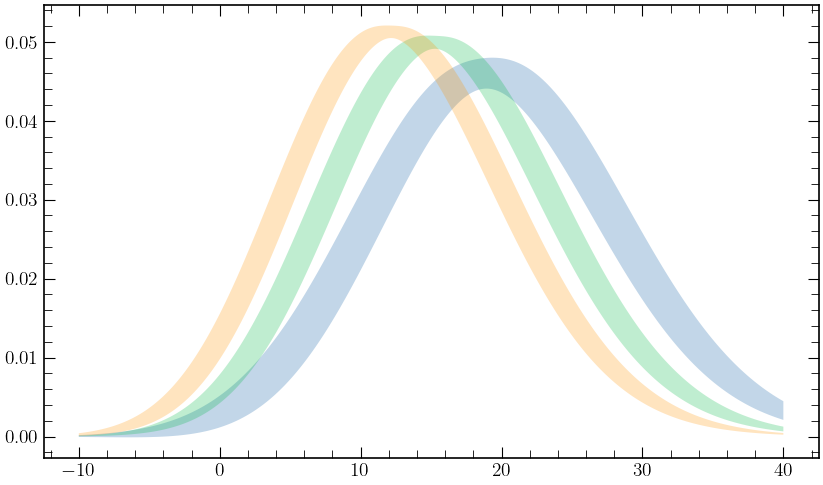

In [369]:
plt.figure(figsize=(10, 6), dpi=100)
for (mn, std) in sets:
    plt.fill_between(x, mn - 1 * std, mn + 1 * std, alpha=0.25)   

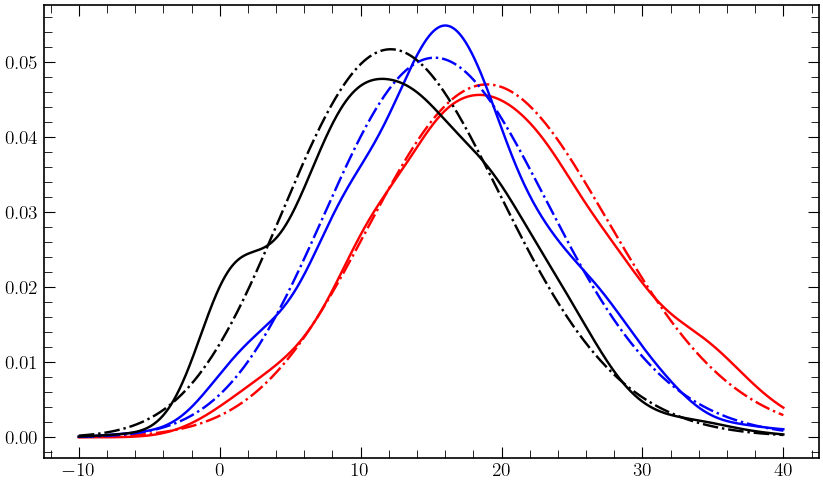

In [370]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(x, kde1(x), color='red')
plt.plot(x, stats.gamma.pdf(x, *p1), color='red', ls="-.")

plt.plot(x, kde2(x), color='blue')
plt.plot(x, stats.gamma.pdf(x, *p2), color='blue', ls='-.')

plt.plot(x, kde3(x), color='k')
plt.plot(x, stats.gamma.pdf(x, *p3), color='k', ls='-.')


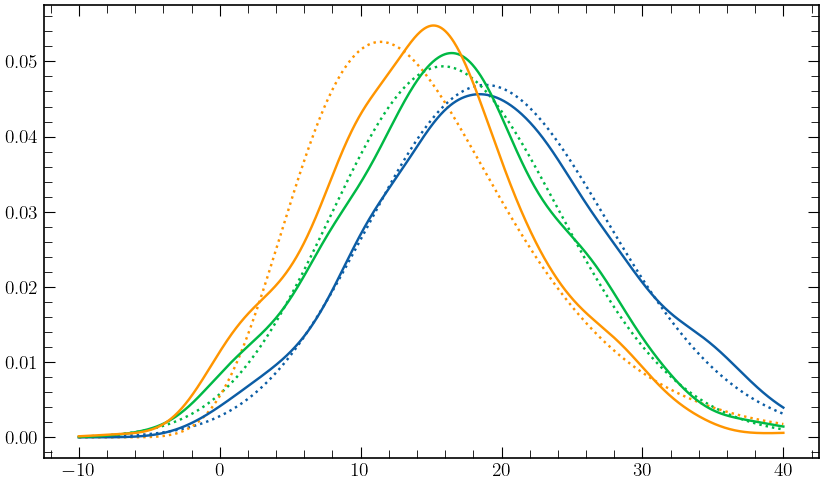

In [69]:
x = np.linspace(-10, 40, 1000)
plt.figure(figsize=(10, 6), dpi=100)
c1 = plt.plot(x, stats.lognorm.pdf(x, *stats.lognorm.fit(data1)), ls=':')
c2 = plt.plot(x, stats.lognorm.pdf(x, *stats.lognorm.fit(data2)), ls=':')
c3 = plt.plot(x, stats.lognorm.pdf(x, *stats.lognorm.fit(data3)), ls=':')

plt.plot(x, kde1(x), color=c1[0].get_color())
plt.plot(x, kde2(x), color=c2[0].get_color())
plt.plot(x, kde3(x), color=c3[0].get_color())

In [53]:


# Define a PyMC3 model
with pm.Model() as model:
    # Define the parameters of the gamma distribution
    #shape = pm.Exponential("shape", lam=1.0)
    #rate = pm.Exponential("rate", lam=1.0)
    shape = pm.Uniform("shape", lower=3, upper=100)
    rate = pm.Uniform("rate", lower=0.1, upper=100)
    
    # Define the likelihood using the gamma distribution
    likelihood = pm.Gamma("likelihood", alpha=shape, beta=rate, observed=data3)
    
    # Perform Bayesian inference
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'shape_interval__': array(0.75877017), 'rate_interval__': array(0.34889797)}

Logp initial evaluation results:
{'shape': -1.53, 'rate': -1.42, 'likelihood': -inf}
You can call `model.debug()` for more details.

In [ ]:
mu_shape, _ = trace.posterior.shape.mean(), trace.posterior.shape.std()
mu_rate, _ = trace.posterior.rate.mean(), trace.posterior.rate.std()

shape, rate = np.array(trace.posterior.shape), np.array(trace.posterior.rate)
C = np.cov(np.column_stack([shape.ravel(), rate.ravel()]).T)
SHAPE, RATE = np.random.multivariate_normal(np.array([mu_shape, mu_rate]), C, size=1000).T

In [ ]:
std = np.std([stats.gamma.pdf(x, SHAPE[i], scale=RATE[i] ** -1) for i in range(1000)], axis=0)
mean = np.mean([stats.gamma.pdf(x, SHAPE[i], scale=RATE[i] ** -1) for i in range(1000)], axis=0)